Identify the Best Run

In [1]:
import pandas as pd

# Load sweep results
df = pd.read_csv('wandb_sweep_results.csv')

# Check column names
print(df.columns)

# Find the best run matching the desired hyperparameters
target_params = {
    'batch_size': 16,
    'learning_rate': 0.000159,
    'dropout': 0.20,
    'l2_reg': 0.00006,
}

# If your CSV stores these columns as floats, rounding may be needed
filtered = df[
    (df['batch_size'] == target_params['batch_size']) &
    (df['learning_rate'].round(6) == target_params['learning_rate']) &
    (df['dropout'].round(2) == target_params['dropout']) &
    (df['l2_reg'].round(5) == target_params['l2_reg'])
]

# Show the run_id and dice for confirmation
print(filtered[['run_id', 'val_dice_coefficient', 'val_loss']])

Index(['base_learning_rate', 'batch_size', 'best_epoch', 'best_val_loss',
       'dice_coefficient', 'dropout', 'epoch', 'epochs', 'graph',
       'input_shape', 'iou_metric', 'l2_reg', 'learning_rate', 'loss',
       'lr_multiplier', 'run_id', 'sweep', 'task', 'test_dice', 'test_iou',
       'test_loss', 'val_dice_coefficient', 'val_iou_metric', 'val_loss',
       'effective_learning_rate'],
      dtype='object')
       run_id  val_dice_coefficient  val_loss
466  rnk45hwn              0.568992  1.100613


Download via W&B Web UI

Download:
https://wandb.ai/tkshfj-bsc-computer-science-university-of-london/classic_unet_segmentation/runs/rnk45hwn/files

Load the Model Checkpoint

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable

@register_keras_serializable()
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

@register_keras_serializable()
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

@register_keras_serializable()
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

# Now load the model
model = tf.keras.models.load_model('../models/unet_final.keras', compile=False)
print("Model loaded!")

2025-07-12 16:44:41.940845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-12 16:44:41.969163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 16:44:41.969202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 16:44:41.970434: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 16:44:41.975805: I tensorflow/core/platform/cpu_feature_guar

Model loaded!


Load an Example from the Dataset

Use the build_dataset function from data_utils.py to load a test sample:

In [3]:
from data_utils import build_dataset

_, _, test_ds = build_dataset(
    metadata_csv='../data/processed/cbis_ddsm_metadata_full.csv',
    input_shape=(256, 256, 1),
    batch_size=8,  # Use batch_size=1 for single-image demonstration
    task='segmentation',
    shuffle=False,
    augment=False
)

Loaded 3746 samples for task: segmentation


Get a Batch for Demonstration

In [4]:
for batch in test_ds.take(1):
    imgs, masks = batch  # imgs: [B, 256, 256, 1], masks: [B, 256, 256, 1]

2025-07-12 16:45:01.801947: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Run Model Prediction

In [5]:
preds = model.predict(imgs)  # preds: [B, 256, 256, 1]

2025-07-12 16:45:06.013692: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-07-12 16:45:06.084254: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-07-12 16:45:06.084276: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-07-12 16:45:06.084347: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 1s 965ms/step


2025-07-12 16:45:06.824819: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [6]:
import numpy as np
preds_bin = (preds > 0.5).astype(np.float32)

Visualize the Results

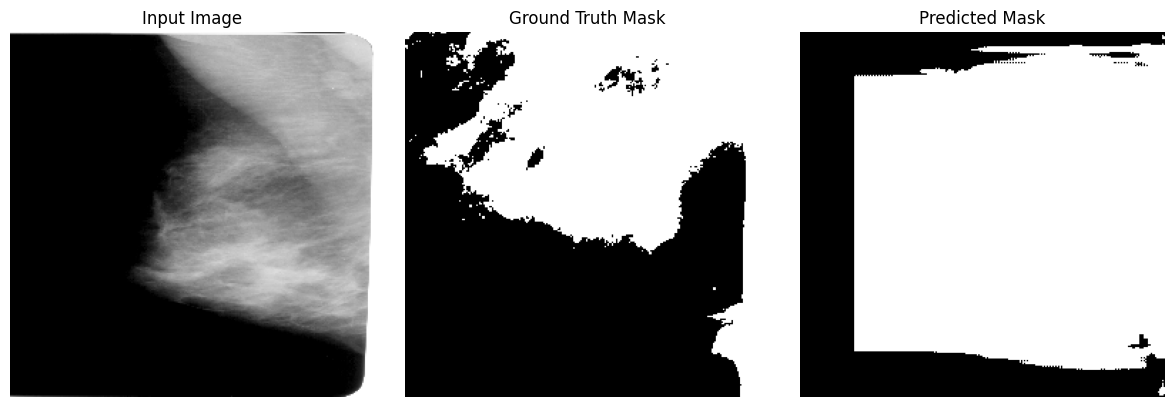

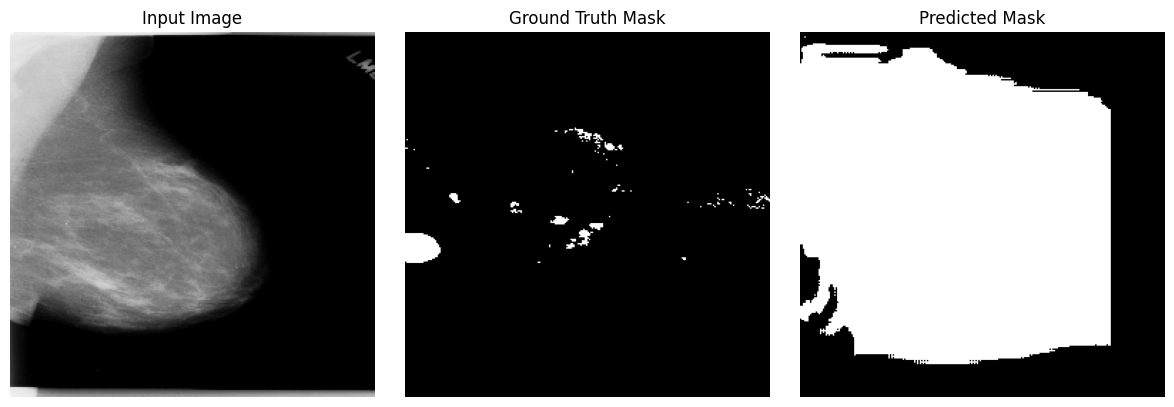

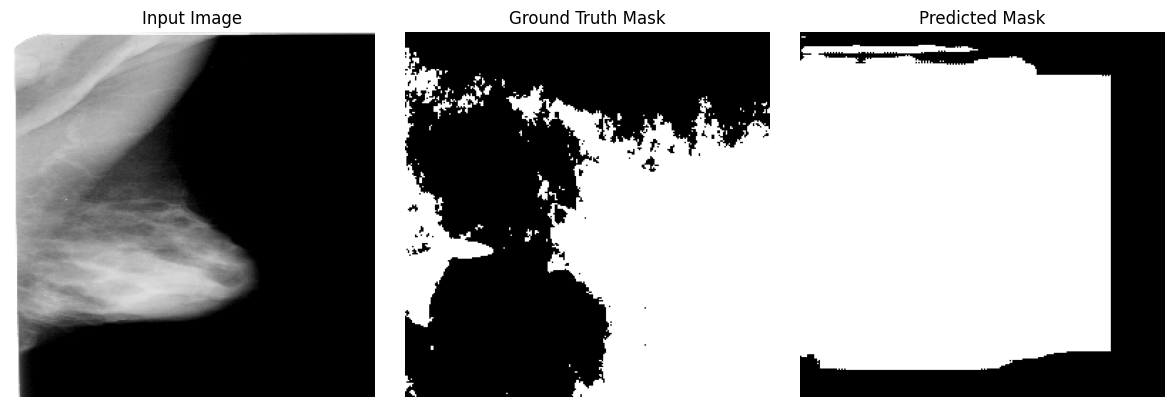

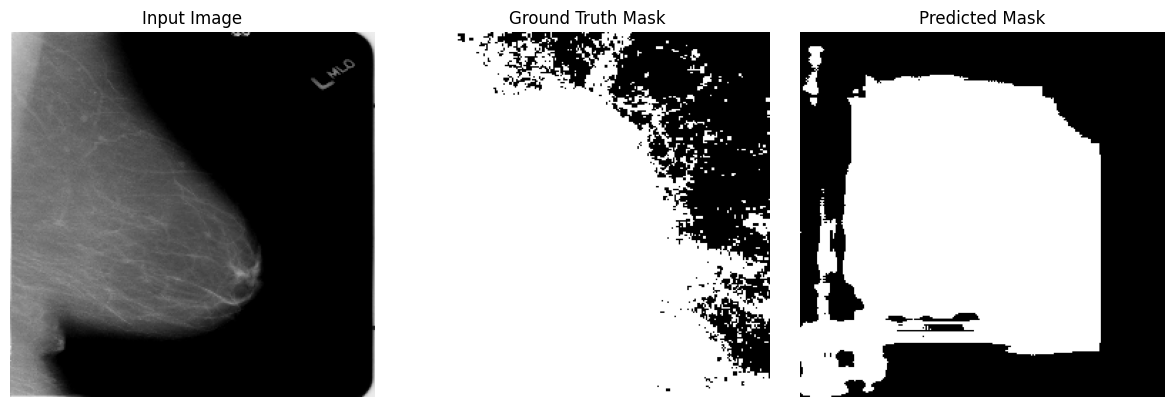

In [7]:
import matplotlib.pyplot as plt

n_examples = min(4, imgs.shape[0])

for i in range(n_examples):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[i, ..., 0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i, ..., 0], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(preds_bin[i, ..., 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()